### In this notebook, I will assemble together all the created features and will train a classifier using classical algorithms. 
### For the NN approach see: https://colab.research.google.com/drive/1CJfc8wpm00y6uO7vjzTHuWA0DFZHnnQJ?usp=sharing

In [62]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, ParameterGrid
from sklearn.metrics import (make_scorer, mean_absolute_error, mean_squared_error, 
                             balanced_accuracy_score, classification_report, confusion_matrix) 


In [63]:
import warnings
warnings.filterwarnings("ignore")

In [85]:
def get_report(y_true, y_pred):
    print("Test accuracy: ", balanced_accuracy_score(y_true, y_pred))
    print("Report: ")
    print(classification_report(y_true, y_pred))
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))

In [65]:
RS = 42  # random state

ros = RandomOverSampler(random_state=RS)

In [66]:
df_features = pd.read_csv("../feature_eng/features.csv", index_col=0)
df_doc_vec = pd.read_csv("../doc2vec/doc_vectors.csv", index_col=0)
df_topics_vec = pd.read_csv('../topics/topics_vectors/topics_floret_128.csv', index_col=0)
df_ner_vec = pd.read_csv("../ner/ent_vectors/ent_floret_128.csv", index_col=0)
labels = pd.read_csv('../data/labels.csv', index_col=0)[['citation_class']]

In [67]:
doc_vec_rename = {c: f'doc_vec_{c}' for c in df_doc_vec.columns}
topics_rename = {c: f'topics_{c}' for c in df_topics_vec.columns}
ner_rename = {c: f'ner_{c}' for c in df_ner_vec.columns}

In [68]:
df_doc_vec = df_doc_vec.rename(columns=doc_vec_rename)
df_topics_vec = df_topics_vec.rename(columns=topics_rename)
df_ner_vec = df_ner_vec.rename(columns=ner_rename)

In [69]:
df = labels.join(df_features.join(df_doc_vec).join(df_topics_vec).join(df_ner_vec))

In [70]:
df.head()

,citation_class,refs_count,telegram_len,month,month_citation_rate_to_global_ratio,year_citation_rate_to_global_ratio,author_all_time_citation_rate_to_global_ratio,author_year_citation_rate_to_global_ratio,author_month_citation_rate_to_global_ratio,author_activity_frac_year,...,ner_246,ner_247,ner_248,ner_249,ner_250,ner_251,ner_252,ner_253,ner_254,ner_255
telegram_index,,,,,,,,,,,,,,,,,,,,,
3_atel,0,0,1010,12,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.665767,2.601700,-1.637177,-1.036830,0.364245,1.445063,0.833967,2.841267,-2.536283,0.211777
2_atel,0,0,907,12,0.0,0.0,0.0,0.0,0.0,1.0,...,-4.171000,0.963690,-0.135300,-1.626400,1.131600,0.922140,-0.832150,0.953610,-2.339500,4.451700
4_atel,0,0,3607,1,0.0,0.0,0.0,0.0,0.0,1.0,...,-4.171000,0.963690,-0.135300,-1.626400,1.131600,0.922140,-0.832150,0.953610,-2.339500,4.451700
5_atel,0,0,1509,1,0.0,0.0,0.0,0.0,0.0,1.0,...,-3.614550,0.216543,-0.777000,-1.012407,0.580325,0.903885,-0.527262,0.909035,-2.082050,2.950850
6_atel,0,0,427,1,0.0,0.0,0.0,0.0,0.0,1.0,...,-3.683900,0.738540,-1.723400,-0.424600,-0.223810,1.120200,-0.117950,2.520900,-2.457300,-0.342590


In [71]:
df.shape

(48279, 659)

In [72]:
df = df.iloc[1000:-100]  # throw away some of the first and some of the last activities

In [73]:
df.shape

(47179, 659)

In [74]:
X, y = df.iloc[:, 1:].values, df.citation_class.values.reshape(-1, 1)

### Start with training LGBM and RF. Overfit on train and check the feature importances:

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=RS, shuffle=True)

In [25]:
gbm = lgb.LGBMClassifier(class_weight='balanced', random_state=RS)
gbm.fit(X_train,y_train)

LGBMClassifier(class_weight='balanced', random_state=42)

In [27]:
y_pred = gbm.predict(X_test)
print(f"Train accuracy: {balanced_accuracy_score(y_train, gbm.predict(X_train))}")
get_report(y_test, y_pred)  

Train accuracy: 0.8914066622356285
Test accuracy:  0.6781549764120499
Report: 
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      5388
           1       0.42      0.56      0.48      1317
           2       0.43      0.67      0.52       372

    accuracy                           0.76      7077
   macro avg       0.59      0.68      0.62      7077
weighted avg       0.80      0.76      0.77      7077

Confusion matrix:
[[4375  895  118]
 [ 370  732  215]
 [  27   97  248]]


In [ ]:
# lgmb is not overfitted enough, try RF

In [39]:
rf = RandomForestClassifier(class_weight='balanced', random_state=RS)
rf.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [40]:
y_pred = rf.predict(X_test)
print(f"Train accuracy: {balanced_accuracy_score(y_train, rf.predict(X_train))}")
get_report(y_test, y_pred)

Train accuracy: 0.9999553112570944
Test accuracy:  0.4942589613781104
Report: 
              precision    recall  f1-score   support

           0       0.82      0.98      0.89      5388
           1       0.62      0.22      0.33      1317
           2       0.60      0.28      0.38       372

    accuracy                           0.80      7077
   macro avg       0.68      0.49      0.53      7077
weighted avg       0.77      0.80      0.76      7077

Confusion matrix:
[[5276   91   21]
 [ 974  295   48]
 [ 179   89  104]]


In [41]:
# that's an overfit! check the importances:

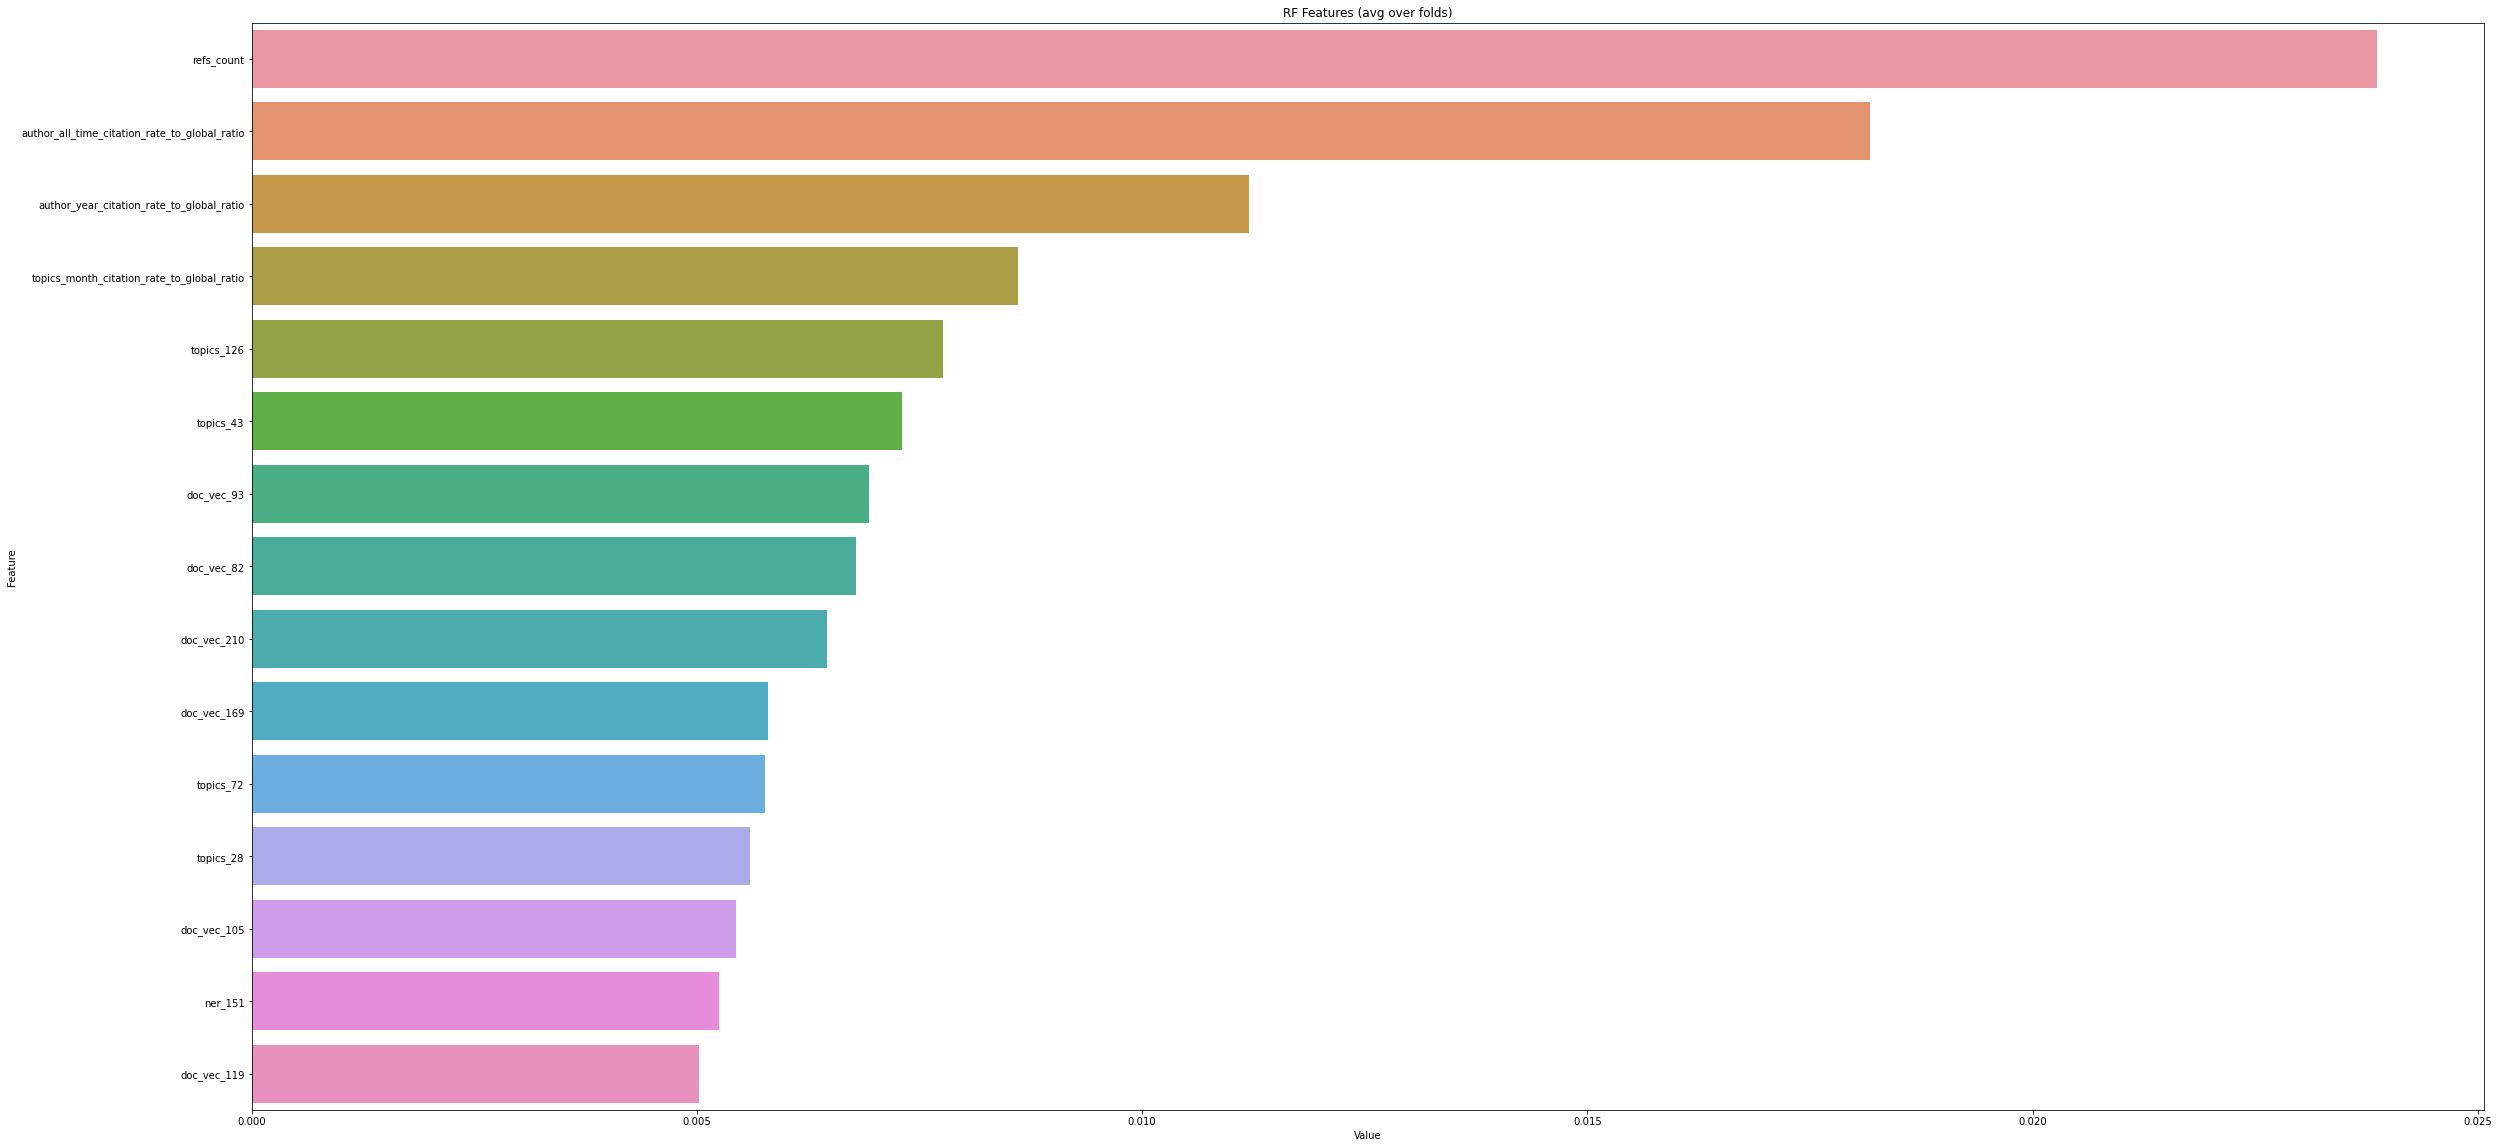

In [42]:
feature_imp = pd.DataFrame({'Value': rf.feature_importances_, 'Feature': df.iloc[:, 1:].columns})

plt.figure(figsize=(40, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:15])
plt.title('RF Features (avg over folds)')
plt.show()

### Try tune RF first (with oversampling and with balanced weights)

In [50]:
# oversampling first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=RS)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [51]:
NFOLDS = 4
kf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=RS)

In [52]:
scorer = make_scorer(balanced_accuracy_score, greater_is_better=True)  

In [53]:
model =  RandomForestClassifier(random_state=RS)

In [57]:
parameters ={
    'max_depth': [3, 5, 7, 10, 70, None],
    'n_estimators': [200, 400, 600, 800, 1000]
}

In [62]:
RSCV = RandomizedSearchCV(model, parameters, scoring=scorer, cv=kf, n_iter=333, verbose=3)

In [63]:
RSCV.fit(X_train, y_train)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
[CV 1/4] END .....max_depth=3, n_estimators=200;, score=0.611 total time= 1.4min
[CV 2/4] END .....max_depth=3, n_estimators=200;, score=0.611 total time= 1.3min
[CV 3/4] END .....max_depth=3, n_estimators=200;, score=0.612 total time= 1.4min
[CV 4/4] END .....max_depth=3, n_estimators=200;, score=0.611 total time= 1.4min
[CV 1/4] END .....max_depth=3, n_estimators=400;, score=0.611 total time= 2.8min
[CV 2/4] END .....max_depth=3, n_estimators=400;, score=0.611 total time= 2.8min
[CV 3/4] END .....max_depth=3, n_estimators=400;, score=0.611 total time= 2.8min
[CV 4/4] END .....max_depth=3, n_estimators=400;, score=0.611 total time= 3.0min
[CV 1/4] END .....max_depth=3, n_estimators=600;, score=0.610 total time= 4.6min
[CV 2/4] END .....max_depth=3, n_estimators=600;, score=0.611 total time= 4.6min
[CV 3/4] END .....max_depth=3, n_estimators=600;, score=0.611 total time= 4.6min
[CV 4/4] END .....max_depth=3, n_estimators=600

RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=333,
                   param_distributions={'max_depth': [3, 5, 7, 10, 70, None],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   scoring=make_scorer(balanced_accuracy_score), verbose=3)

In [64]:
best_estimator = RSCV.best_estimator_

In [65]:
y_pred = best_estimator.predict(X_test)
print(f"Train accuracy: {balanced_accuracy_score(y_train, best_estimator.predict(X_train))}")
get_report(y_test, y_pred)

Train accuracy: 1.0
Test accuracy:  0.5505363324476544
Report: 
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      5388
           1       0.54      0.34      0.42      1317
           2       0.59      0.36      0.45       372

    accuracy                           0.81      7077
   macro avg       0.66      0.55      0.59      7077
weighted avg       0.78      0.81      0.78      7077

Confusion matrix:
[[5123  237   28]
 [ 808  445   64]
 [  94  143  135]]


In [66]:
RSCV.best_params_ 

{'n_estimators': 1000, 'max_depth': 70}

In [69]:
# # no oversampling
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=RS)

# model =  RandomForestClassifier(class_weight='balanced', random_state=RS)
# RSCV = RandomizedSearchCV(model, parameters, scoring=scorer, cv=kf, n_iter=333, verbose=1)

In [70]:
# RSCV.fit(X_train, y_train)

In [71]:
# best_estimator = RSCV.best_estimator_
# y_pred = best_estimator.predict(X_test)
# print(f"Train accuracy: {balanced_accuracy_score(y_train, best_estimator.predict(X_train))}")
# get_report(y_test, y_pred)

In [73]:
# RSCV.best_params_ 

### LGBM:

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=RS)
# X_train, y_train = ros.fit_resample(X_train, y_train)

NFOLDS = 4
kf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=RS)

scorer = make_scorer(balanced_accuracy_score, greater_is_better=True)  

model = lgb.LGBMClassifier(class_weight='balanced', random_state=RS)

parameters = {
    'n_estimators': [100, 250, 500, 1000],
    'max_depth': [2, 4, 6, -1],
    'reg_alpha': [0.1, 1],
    'learning_rate': [0.001, 0.01, 0.1]
}

RSCV = RandomizedSearchCV(model, parameters, scoring=scorer, cv=kf, n_iter=333, verbose=1)

In [75]:
RSCV.fit(X_train, y_train)

Fitting 4 folds for each of 96 candidates, totalling 384 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
                   estimator=LGBMClassifier(class_weight='balanced',
                                            random_state=42),
                   n_iter=333,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': [2, 4, 6, -1],
                                        'n_estimators': [100, 250, 500, 1000],
                                        'reg_alpha': [0.1, 1]},
                   scoring=make_scorer(balanced_accuracy_score), verbose=1)

In [76]:
best_estimator = RSCV.best_estimator_

y_pred = best_estimator.predict(X_test)
print(f"Train accuracy: {balanced_accuracy_score(y_train, best_estimator.predict(X_train))}")
get_report(y_test, y_pred)

Train accuracy: 0.7965354769547096
Test accuracy:  0.6843542334614909
Report: 
              precision    recall  f1-score   support

           0       0.91      0.81      0.86      5388
           1       0.41      0.51      0.46      1317
           2       0.39      0.74      0.51       372

    accuracy                           0.75      7077
   macro avg       0.57      0.68      0.61      7077
weighted avg       0.79      0.75      0.76      7077

Confusion matrix:
[[4340  878  170]
 [ 381  673  263]
 [  25   73  274]]


In [77]:
RSCV.best_params_ 

{'reg_alpha': 0.1, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.01}

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=RS)

In [85]:
gbm = lgb.LGBMClassifier(class_weight='balanced', random_state=RS, 
                         **{'reg_alpha': 0.1, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.01})
gbm.fit(X_train,y_train)

LGBMClassifier(class_weight='balanced', learning_rate=0.01, max_depth=6,
               n_estimators=500, random_state=42, reg_alpha=0.1)

In [86]:
y_pred = gbm.predict(X_test)
print(f"Train accuracy: {balanced_accuracy_score(y_train, gbm.predict(X_train))}")
get_report(y_test, y_pred)  

Train accuracy: 0.7965354769547096
Test accuracy:  0.6843542334614909
Report: 
              precision    recall  f1-score   support

           0       0.91      0.81      0.86      5388
           1       0.41      0.51      0.46      1317
           2       0.39      0.74      0.51       372

    accuracy                           0.75      7077
   macro avg       0.57      0.68      0.61      7077
weighted avg       0.79      0.75      0.76      7077

Confusion matrix:
[[4340  878  170]
 [ 381  673  263]
 [  25   73  274]]


In [93]:
gbm = lgb.LGBMClassifier(class_weight='balanced', random_state=RS, 
                         **{'reg_alpha': 0.1, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.01, 'reg_lambda': 0.01})
gbm.fit(X_train,y_train)

LGBMClassifier(class_weight='balanced', learning_rate=0.01, max_depth=6,
               n_estimators=500, random_state=42, reg_alpha=0.1,
               reg_lambda=0.01)

In [94]:
y_pred = gbm.predict(X_test)
print(f"Train accuracy: {balanced_accuracy_score(y_train, gbm.predict(X_train))}")
get_report(y_test, y_pred)  

Train accuracy: 0.7965630906173726
Test accuracy:  0.6852502908091612
Report: 
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      5388
           1       0.41      0.51      0.46      1317
           2       0.39      0.74      0.51       372

    accuracy                           0.75      7077
   macro avg       0.57      0.69      0.61      7077
weighted avg       0.79      0.75      0.76      7077

Confusion matrix:
[[4340  883  165]
 [ 376  673  268]
 [  25   72  275]]


### Investigate the multi-label feature importances

In [81]:
np.unique(y_train), np.unique(y_test)

(array([0, 1, 2]), array([0, 1, 2]))

In [82]:
gbm = lgb.LGBMClassifier(class_weight='balanced', random_state=RS, 
                         **{'reg_alpha': 0.1, 'n_estimators': 550, 'max_depth': 6, 'learning_rate': 0.01, 'reg_lambda': 0.01})
gbm.fit(X_train,y_train)

y_pred = gbm.predict(X_test)
print(f"Train accuracy: {balanced_accuracy_score(y_train, gbm.predict(X_train))}")
get_report(y_test, y_pred)  

Train accuracy: 0.8040886978779529
Test accuracy:  0.687138338751291
Report: 
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      5388
           1       0.42      0.52      0.46      1317
           2       0.39      0.74      0.51       372

    accuracy                           0.75      7077
   macro avg       0.57      0.69      0.61      7077
weighted avg       0.80      0.75      0.77      7077

Confusion matrix:
[[4340  886  162]
 [ 370  684  263]
 [  26   72  274]]


In [83]:
feature_imp = pd.DataFrame({'Value': gbm.feature_importances_, 'Feature': df.iloc[:, 1:].columns})

ner_imp = feature_imp.iloc[-256:].Value.sum()
ner_label = 'NER Vector'
feature_imp = feature_imp.iloc[:-256]

topics_imp = feature_imp.iloc[-128:].Value.sum()
topics_label = 'Topics Vector'
feature_imp = feature_imp.iloc[:-128]

doc_imp = feature_imp.iloc[-256:].Value.sum()
doc_label = 'Document Vector'
feature_imp = feature_imp.iloc[:-256]

ner_df = pd.DataFrame({'Value': ner_imp, "Feature": ner_label}, index=[0])
topics_df = pd.DataFrame({'Value': topics_imp, "Feature": topics_label}, index=[0])
doc_df = pd.DataFrame({'Value': doc_imp, "Feature": doc_label}, index=[0])

feature_imp = pd.concat([feature_imp, ner_df, topics_df, doc_df])

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


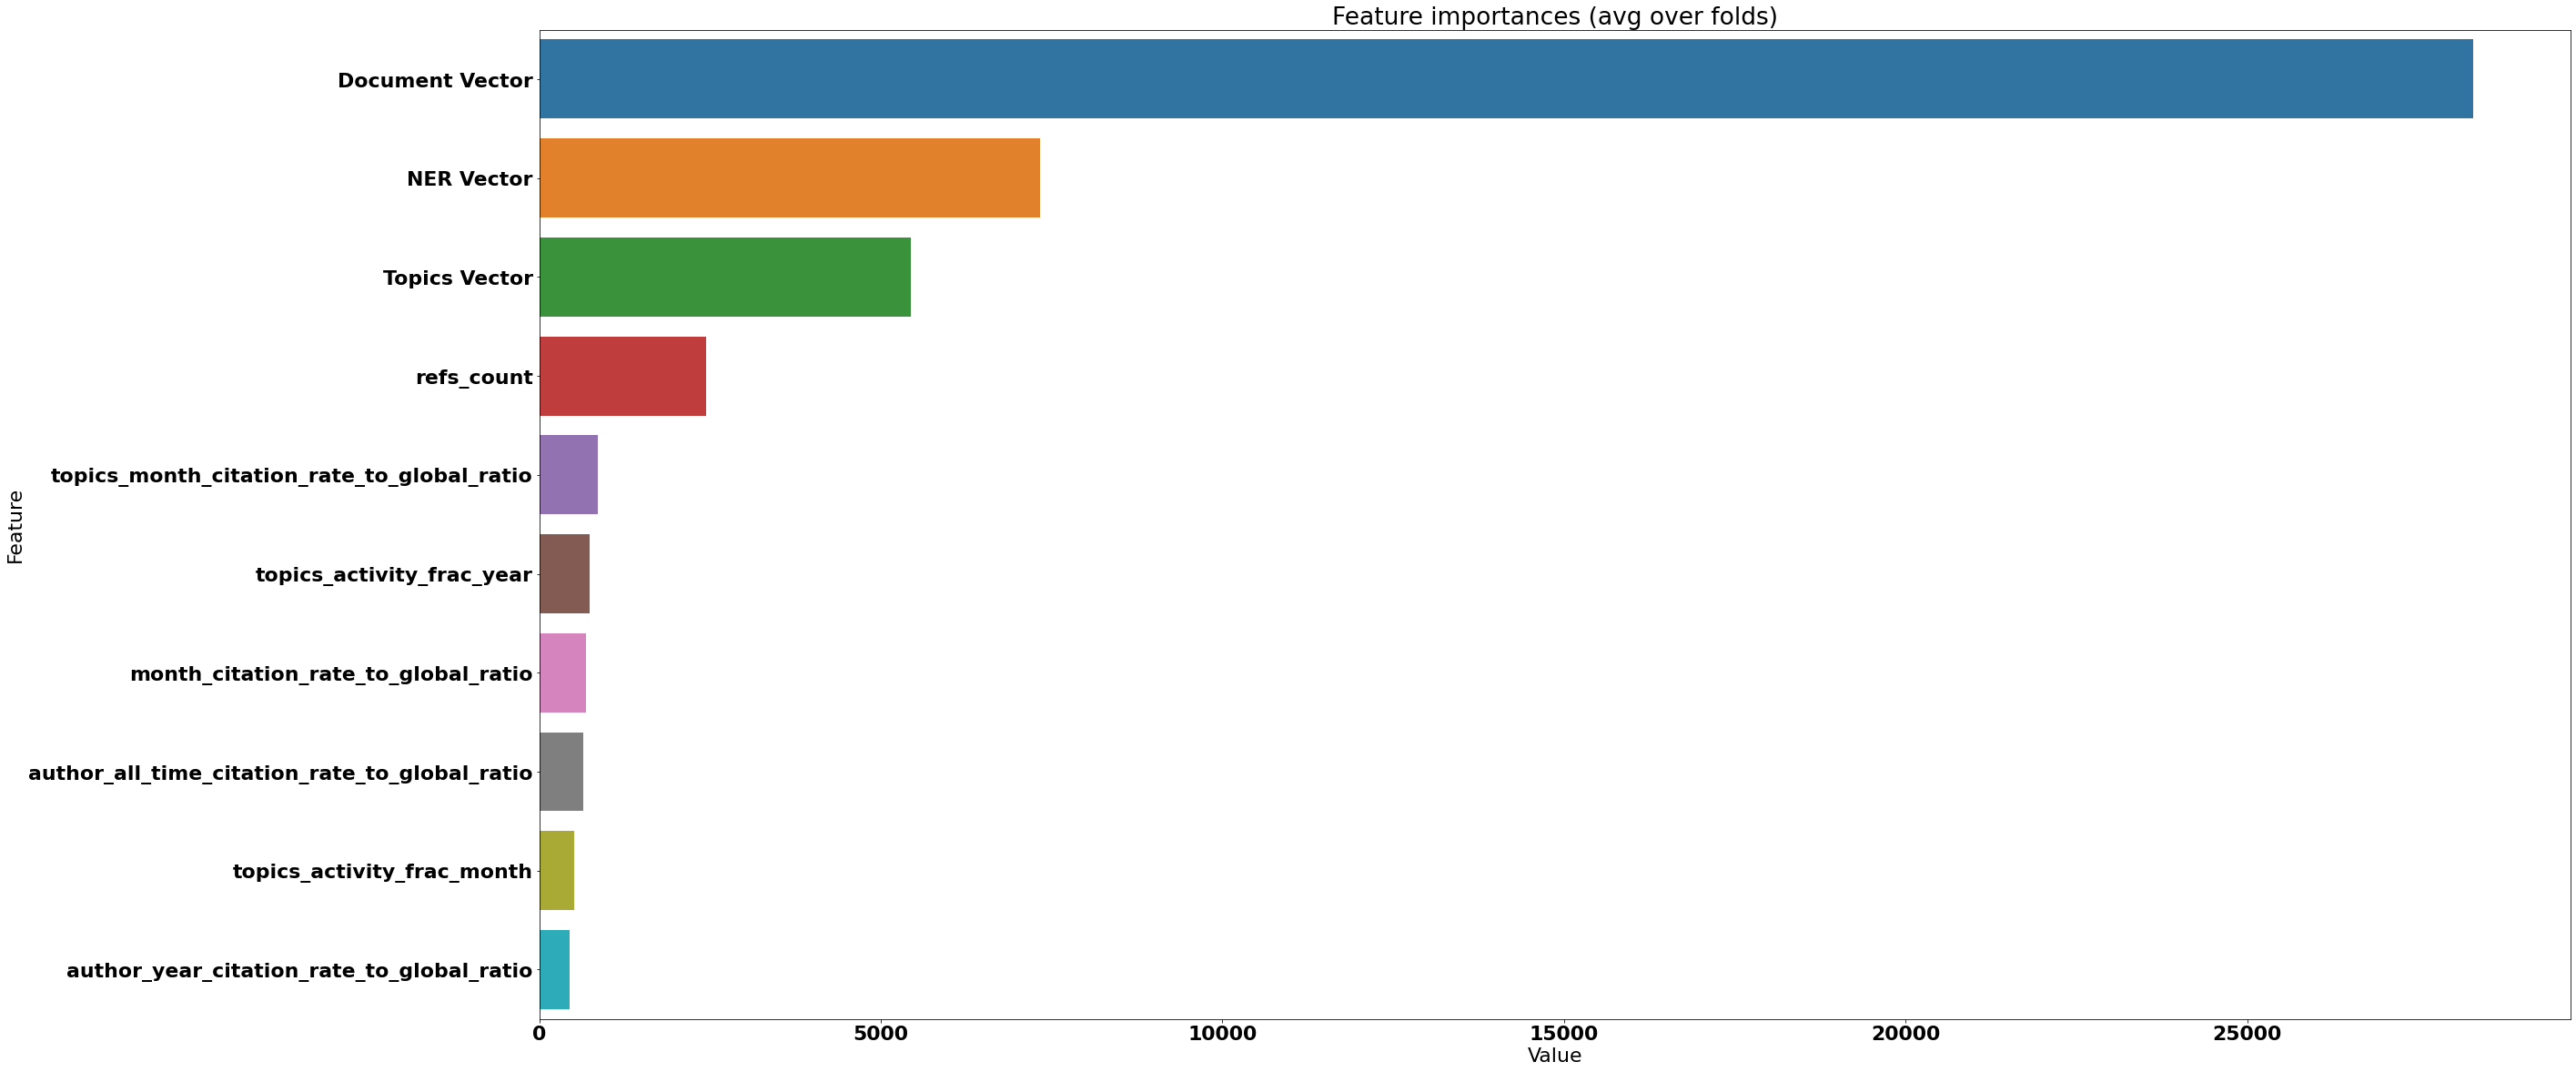

In [84]:
plt.figure(figsize=(40, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:10])
plt.title('Feature importances (avg over folds)')
plt.show()

In [102]:
# to binary and check the metrics

In [103]:
y_pred_binary = (y_pred > 0).astype(int)
y_test_binary = (y_test > 0).astype(int)

get_report(y_test_binary, y_pred_binary)  

Test accuracy:  0.7855177151778638
Report: 
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      5388
           1       0.55      0.77      0.64      1689

    accuracy                           0.80      7077
   macro avg       0.73      0.79      0.75      7077
weighted avg       0.83      0.80      0.81      7077

Confusion matrix:
[[4340 1048]
 [ 396 1293]]


### Train binary

In [16]:
y[y>1] = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=RS)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=RS)

NFOLDS = 4
kf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=RS)

scorer = make_scorer(balanced_accuracy_score, greater_is_better=True)  

model = lgb.LGBMClassifier(class_weight='balanced', random_state=RS)

parameters = {
    'n_estimators': [250, 500, 750, 1000],
    'max_depth': [2, 4, 6, 8],
    'reg_alpha': [0.1, 0.5, 1],
    'reg_lambda': [0.01, 0.05],
    'learning_rate': [0.001, 0.01]
}

RSCV = RandomizedSearchCV(model, parameters, scoring=scorer, cv=kf, n_iter=333, verbose=1)

In [18]:
RSCV.fit(X_train, y_train)

Fitting 4 folds for each of 192 candidates, totalling 768 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
                   estimator=LGBMClassifier(class_weight='balanced',
                                            random_state=42),
                   n_iter=333,
                   param_distributions={'learning_rate': [0.001, 0.01],
                                        'max_depth': [2, 4, 6, 8],
                                        'n_estimators': [250, 500, 750, 1000],
                                        'reg_alpha': [0.1, 0.5, 1],
                                        'reg_lambda': [0.01, 0.05]},
                   scoring=make_scorer(balanced_accuracy_score), verbose=1)

In [19]:
best_estimator = RSCV.best_estimator_

y_pred = best_estimator.predict(X_test)
print(f"Train accuracy: {balanced_accuracy_score(y_train, best_estimator.predict(X_train))}")
get_report(y_test, y_pred)

Train accuracy: 0.8733535632715986
Test accuracy:  0.7949134712887398
Report: 
              precision    recall  f1-score   support

           0       0.91      0.84      0.88      5388
           1       0.59      0.75      0.66      1689

    accuracy                           0.82      7077
   macro avg       0.75      0.79      0.77      7077
weighted avg       0.84      0.82      0.82      7077

Confusion matrix:
[[4521  867]
 [ 421 1268]]


In [20]:
RSCV.best_params_

{'reg_lambda': 0.05,
 'reg_alpha': 0.5,
 'n_estimators': 1000,
 'max_depth': 8,
 'learning_rate': 0.01}

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=RS)

NFOLDS = 4
kf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=RS)

scorer = make_scorer(balanced_accuracy_score, greater_is_better=True)  

model = lgb.LGBMClassifier(class_weight='balanced', random_state=RS)

parameters = {
    'n_estimators': np.arange(925, 1100, 25),
    'max_depth': [7, 8, 9],
    'reg_alpha': [0.4, 0.5, 0.6],
    'reg_lambda': [0.04, 0.05, 0.06],
    'learning_rate': [0.01]
}

RSCV = RandomizedSearchCV(model, parameters, scoring=scorer, cv=kf, n_iter=333, verbose=1)

In [30]:
RSCV.fit(X_train, y_train)

Fitting 4 folds for each of 189 candidates, totalling 756 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
                   estimator=LGBMClassifier(class_weight='balanced',
                                            random_state=42),
                   n_iter=333,
                   param_distributions={'learning_rate': [0.01],
                                        'max_depth': [7, 8, 9],
                                        'n_estimators': array([ 925,  950,  975, 1000, 1025, 1050, 1075]),
                                        'reg_alpha': [0.4, 0.5, 0.6],
                                        'reg_lambda': [0.04, 0.05, 0.06]},
                   scoring=make_scorer(balanced_accuracy_score), verbose=1)

In [31]:
best_estimator = RSCV.best_estimator_

y_pred = best_estimator.predict(X_test)
print(f"Train accuracy: {balanced_accuracy_score(y_train, best_estimator.predict(X_train))}")
get_report(y_test, y_pred)

Train accuracy: 0.8698910447348482
Test accuracy:  0.7920812119821563
Report: 
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      5388
           1       0.59      0.75      0.66      1689

    accuracy                           0.82      7077
   macro avg       0.75      0.79      0.77      7077
weighted avg       0.84      0.82      0.82      7077

Confusion matrix:
[[4516  872]
 [ 429 1260]]


In [32]:
RSCV.best_params_

{'reg_lambda': 0.06,
 'reg_alpha': 0.5,
 'n_estimators': 950,
 'max_depth': 8,
 'learning_rate': 0.01}